In [32]:
import os
from pathlib import Path
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = Path().absolute().parent.parent / 'lmdb'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

# Simple CNN baseline

pytorch and lmdb are required for this baseline implementation

## Baseline method

- Naively resize to 32x32 (DON'T DO THIS IN YOUR WORK, try to save geometry somehow, it is important)
- Train LeNet-like CNN
- Enjoy :)

In [33]:
import cv2
import numpy as np

### Data tools

In [34]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [35]:
train_helper, val_helper = train_helper.train_val_split()

In [36]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [37]:
img, label = train_helper.get_item(42)

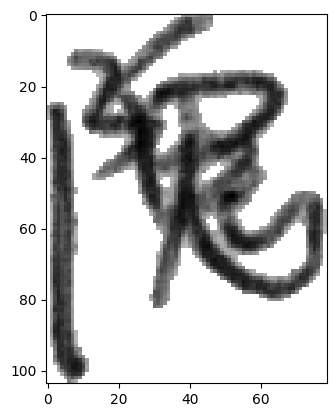

In [38]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [39]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (32, 32)) - 127.5) / 255., label

In [40]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

### Model & training

In [41]:
class LeNet(nn.Module):
    def __init__(self, n_classes):
        super(LeNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [16, 16, 8] 
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2)), # [8, 8, 16]
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [4, 4, 32]
            
            nn.Flatten(),
            nn.Linear(4 * 4 * 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, n_classes, bias=False)
        )
    
    def forward(self, x):
        return self.nn(x)

In [42]:
model = LeNet(train_helper.vocabulary.num_classes())
model.eval()

LeNet(
  (nn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=T

In [43]:
model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 1, 32, 32))

tensor([[ 0.0077, -0.0035,  0.0146,  ...,  0.0103,  0.0010,  0.0185]],
       grad_fn=<MmBackward0>)

In [44]:
model = model.cuda()

In [45]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)

In [46]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [47]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [48]:
torch.save(model.state_dict(), 'baseline.pth')

In [49]:
for epoch in range(10):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'baseline_epoch{epoch}.pth')

Epoch 0:


100%|██████████| 315/315 [01:56<00:00,  2.71it/s]


accuracy: 0.7806918612678383
Epoch 1:


100%|██████████| 315/315 [01:39<00:00,  3.17it/s]


accuracy: 0.7665204798567814
Epoch 2:


100%|██████████| 315/315 [01:36<00:00,  3.25it/s]


accuracy: 0.8079471431518952
Epoch 3:


100%|██████████| 315/315 [02:03<00:00,  2.56it/s]


accuracy: 0.7989727105888996
Epoch 4:


100%|██████████| 315/315 [01:58<00:00,  2.66it/s]


accuracy: 0.8261814526325261
Epoch 5:


100%|██████████| 315/315 [01:46<00:00,  2.97it/s]


accuracy: 0.8280011603933547
Epoch 6:


100%|██████████| 315/315 [01:50<00:00,  2.85it/s]


accuracy: 0.8247976680437288
Epoch 7:


100%|██████████| 315/315 [02:42<00:00,  1.94it/s]


accuracy: 0.8158899425853502
Epoch 8:


100%|██████████| 315/315 [03:03<00:00,  1.72it/s]


accuracy: 0.8238963464673934
Epoch 9:


100%|██████████| 315/315 [03:01<00:00,  1.74it/s]

accuracy: 0.8046815976816954


### Evaluation

In [50]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [53]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0)

In [54]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|██████████| 380/380 [01:58<00:00,  3.20it/s]


In [62]:
with open(pred_path, 'w', encoding="utf-8") as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [73]:
#from course_intro_ocr_t2.evaluate import evaluate
def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path, encoding="utf-8") as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls
    
    n_good = 0
    n_all = len(gt)
    with open(pred_path, encoding="utf-8") as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1
    
    return n_good / n_all


def _run_evaluation():
    base = Path(__file__).absolute().parent.parent
    gt_path = base / 'gt.txt'
    pred_path = base / 'pred.txt'
    score = evaluate(gt_path, pred_path)
    print('Accuracy = {:1.4f}'.format(score))
evaluate(gt_path, pred_path)
#evaluate()

0.7688336340327331